### https://github.com/jinglescode/time-series-forecasting-pytorch/blob/main/demo-predicting-stock-prices.ipynb

In [10]:
import pandas as pd
import numpy as np
import seaborn as sn

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
%matplotlib inline

In [3]:
from lutils.fin.data_loader import load

In [4]:
df = load('SHFE', 'rb2305')

load Z:/tq_data/ticks\SHFE.rb2305.h5
load Y:/fin_data\2023-05-04\SHFE.rb2305.h5
load Y:/fin_data\2023-05-05\SHFE.rb2305.h5
load Y:/fin_data\2023-05-08\SHFE.rb2305.h5
load Y:/fin_data\2023-05-09\SHFE.rb2305.h5
load Y:/fin_data\2023-05-10\SHFE.rb2305.h5
load Y:/fin_data\2023-05-11\SHFE.rb2305.h5
load Y:/fin_data\2023-05-12\SHFE.rb2305.h5
load Y:/fin_data\2023-05-15\SHFE.rb2305.h5


In [ ]:
start_date = '2023-01-01'
end_date = ''

In [5]:
df.index = df.datetime

In [6]:
df = df['2023-02-01':]

In [18]:
resample_1T = df.resample('1T').last()

In [19]:
resample_1T = resample_1T.ffill().bfill()

In [20]:
df_1T = pd.concat([resample_1T.between_time('09:00', '10:15'), 
          resample_1T.between_time('10:30', '11:30'),
          resample_1T.between_time('13:30', '15:00'),
          resample_1T.between_time('21:00', '23:00')], axis=0).sort_index()[['last_price', 'volume', 'amount']]

In [21]:
df_1T

,last_price,volume,amount
datetime,,,
2023-02-01 09:00:00,4171.0,484508.0,2.005672e+10
2023-02-01 09:01:00,4175.0,508494.0,2.105791e+10
2023-02-01 09:02:00,4173.0,520963.0,2.157821e+10
2023-02-01 09:03:00,4169.0,526476.0,2.180817e+10
2023-02-01 09:04:00,4169.0,530392.0,2.197143e+10
...,...,...,...
2023-05-15 14:56:00,3485.0,810.0,2.806440e+07
2023-05-15 14:57:00,3482.0,870.0,3.015450e+07
2023-05-15 14:58:00,3482.0,870.0,3.015450e+07


In [25]:
# price_data = df.close
price_data = df_1T.last_price.diff(1).fillna(0)

<AxesSubplot:xlabel='last_price', ylabel='Count'>

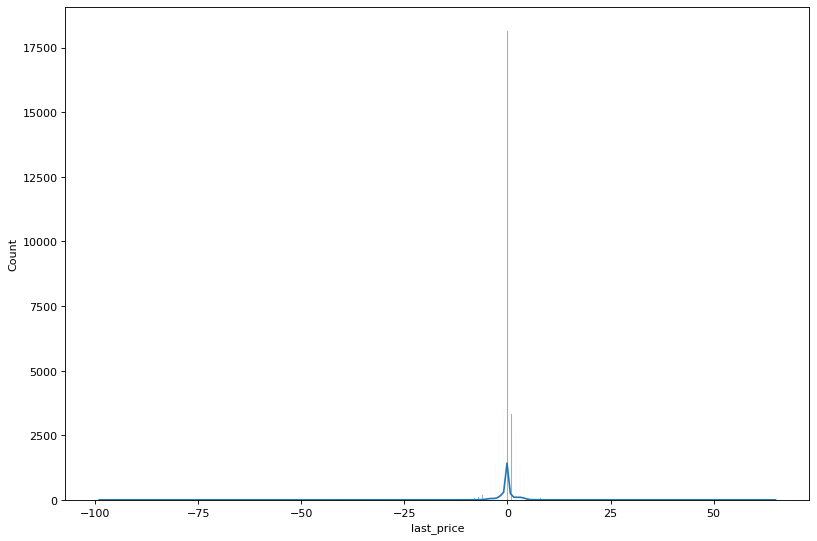

In [27]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=80)
sn.histplot(price_data, kde=True, ax=ax)

In [31]:
config = {
#     "alpha_vantage": {
#         "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
#         "symbol": "IBM",
#         "outputsize": "full",
#         "key_adjusted_close": "5. adjusted close",
#     },
    'symbol': 'rb2305',
    "data": {
        "window_size": 30,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 400,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [32]:
num_data_points = df_1T.shape[0]

In [33]:
data_close_price = price_data.to_numpy()

In [34]:
data_date = df_1T.index.strftime('%Y-%m-%d %H-%M').to_list()
# data_date.reverse()

In [35]:
display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]

D:\Software\Python\torch\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


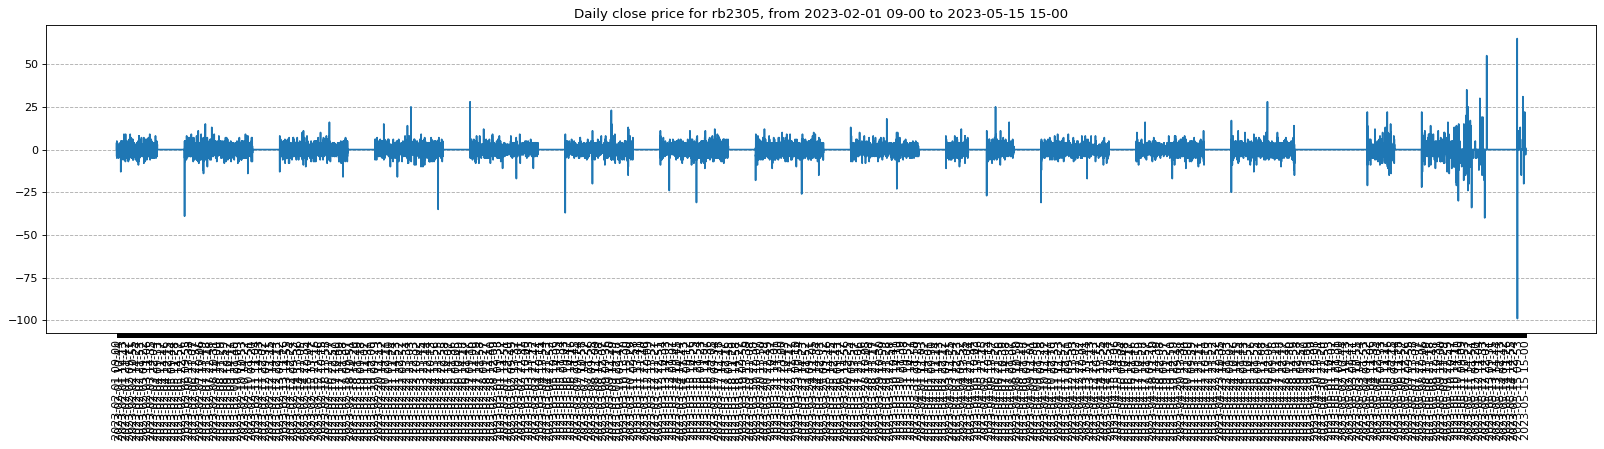

In [36]:
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, price_data)
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')

In [37]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(price_data.to_numpy())

D:\Software\Python\torch\lib\site-packages\ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


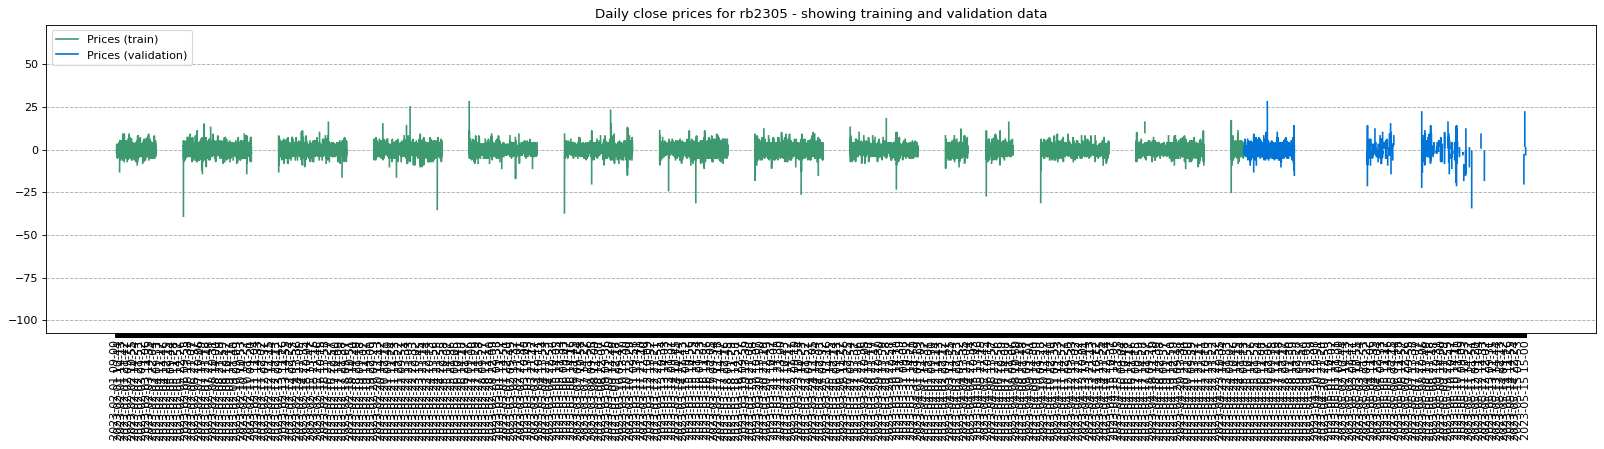

In [38]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["symbol"] + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=True)

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (28916, 30, 1) (28916,)
Validation data shape (7229, 30, 1) (7229,)


In [40]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [19]:
# class GRUModel(nn.Module):
#     def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size

#         self.linear_1 = nn.Linear(input_size, hidden_layer_size)
#         self.relu = nn.ReLU()
#         self.gru = nn.GRU(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
#         self.dropout = nn.Dropout(dropout)
#         self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
#         self.init_weights()

#     def init_weights(self):
#         for name, param in self.gru.named_parameters():
#             if 'bias' in name:
#                  nn.init.constant_(param, 0.0)
#             elif 'weight_ih' in name:
#                  nn.init.kaiming_normal_(param)
#             elif 'weight_hh' in name:
#                  nn.init.orthogonal_(param)

#     def forward(self, x):
#         batchsize = x.shape[0]

#         # layer 1
#         x = self.linear_1(x)
#         x = self.relu(x)
        
#         # GRU layer
#         gru_out, (h_n) = self.gru(x)

#         # reshape output from hidden cell into [batch, features] for `linear_2`
#         x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
#         # layer 2
#         x = self.dropout(x)
#         predictions = self.linear_2(x)
#         return predictions[:,-1]

# model = GRUModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
# model = model.to(config["training"]["device"])

In [41]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/400] | loss train:6.240521, test:2.573876 | lr:0.010000
Epoch[2/400] | loss train:6.230033, test:2.572428 | lr:0.010000
Epoch[3/400] | loss train:6.224968, test:2.576490 | lr:0.010000
Epoch[4/400] | loss train:6.220560, test:2.574236 | lr:0.010000
Epoch[5/400] | loss train:6.225333, test:2.580085 | lr:0.010000
Epoch[6/400] | loss train:6.227022, test:2.586317 | lr:0.010000
Epoch[7/400] | loss train:6.224321, test:2.575611 | lr:0.010000
Epoch[8/400] | loss train:6.227183, test:2.573011 | lr:0.010000
Epoch[9/400] | loss train:6.213345, test:2.573721 | lr:0.010000
Epoch[10/400] | loss train:6.221231, test:2.572453 | lr:0.010000
Epoch[11/400] | loss train:6.221665, test:2.577146 | lr:0.010000
Epoch[12/400] | loss train:6.215688, test:2.573205 | lr:0.010000
Epoch[13/400] | loss train:6.216436, test:2.575232 | lr:0.010000
Epoch[14/400] | loss train:6.215017, test:2.573069 | lr:0.010000
Epoch[15/400] | loss train:6.215297, test:2.572804 | lr:0.010000
Epoch[16/400] | loss train:6.21454

Epoch[127/400] | loss train:6.190316, test:2.569553 | lr:0.000010
Epoch[128/400] | loss train:6.189189, test:2.569650 | lr:0.000010
Epoch[129/400] | loss train:6.188537, test:2.569907 | lr:0.000010
Epoch[130/400] | loss train:6.193620, test:2.575243 | lr:0.000010
Epoch[131/400] | loss train:6.187016, test:2.569612 | lr:0.000010
Epoch[132/400] | loss train:6.184949, test:2.569957 | lr:0.000010
Epoch[133/400] | loss train:6.185139, test:2.569280 | lr:0.000010
Epoch[134/400] | loss train:6.221599, test:2.574051 | lr:0.000010
Epoch[135/400] | loss train:6.190072, test:2.570449 | lr:0.000010
Epoch[136/400] | loss train:6.190531, test:2.572597 | lr:0.000010
Epoch[137/400] | loss train:6.189394, test:2.569706 | lr:0.000010
Epoch[138/400] | loss train:6.189607, test:2.570398 | lr:0.000010
Epoch[139/400] | loss train:6.188241, test:2.571271 | lr:0.000010
Epoch[140/400] | loss train:6.188271, test:2.569790 | lr:0.000010
Epoch[141/400] | loss train:6.187290, test:2.569921 | lr:0.000010
Epoch[142/

Epoch[252/400] | loss train:6.186839, test:2.573965 | lr:0.000000
Epoch[253/400] | loss train:6.186665, test:2.571786 | lr:0.000000
Epoch[254/400] | loss train:6.191570, test:2.571909 | lr:0.000000
Epoch[255/400] | loss train:6.193321, test:2.570290 | lr:0.000000
Epoch[256/400] | loss train:6.210619, test:2.572007 | lr:0.000000
Epoch[257/400] | loss train:6.193491, test:2.569778 | lr:0.000000
Epoch[258/400] | loss train:6.192822, test:2.573452 | lr:0.000000
Epoch[259/400] | loss train:6.191776, test:2.569752 | lr:0.000000
Epoch[260/400] | loss train:6.190349, test:2.575329 | lr:0.000000
Epoch[261/400] | loss train:6.185509, test:2.570110 | lr:0.000000
Epoch[262/400] | loss train:6.186219, test:2.574429 | lr:0.000000
Epoch[263/400] | loss train:6.187438, test:2.569746 | lr:0.000000
Epoch[264/400] | loss train:6.191645, test:2.570181 | lr:0.000000
Epoch[265/400] | loss train:6.196717, test:2.570242 | lr:0.000000
Epoch[266/400] | loss train:6.191335, test:2.571533 | lr:0.000000
Epoch[267/

Epoch[377/400] | loss train:6.189654, test:2.570041 | lr:0.000000
Epoch[378/400] | loss train:6.192142, test:2.571163 | lr:0.000000
Epoch[379/400] | loss train:6.189528, test:2.569598 | lr:0.000000
Epoch[380/400] | loss train:6.191879, test:2.570985 | lr:0.000000
Epoch[381/400] | loss train:6.185244, test:2.572506 | lr:0.000000
Epoch[382/400] | loss train:6.191612, test:2.569615 | lr:0.000000
Epoch[383/400] | loss train:6.197398, test:2.569563 | lr:0.000000
Epoch[384/400] | loss train:6.196948, test:2.612948 | lr:0.000000
Epoch[385/400] | loss train:6.187002, test:2.569910 | lr:0.000000
Epoch[386/400] | loss train:6.189723, test:2.577320 | lr:0.000000
Epoch[387/400] | loss train:6.188540, test:2.569764 | lr:0.000000
Epoch[388/400] | loss train:6.191546, test:2.569304 | lr:0.000000
Epoch[389/400] | loss train:6.193523, test:2.570551 | lr:0.000000
Epoch[390/400] | loss train:6.191575, test:2.569906 | lr:0.000000
Epoch[391/400] | loss train:6.189197, test:2.570058 | lr:0.000000
Epoch[392/

D:\Software\Python\torch\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


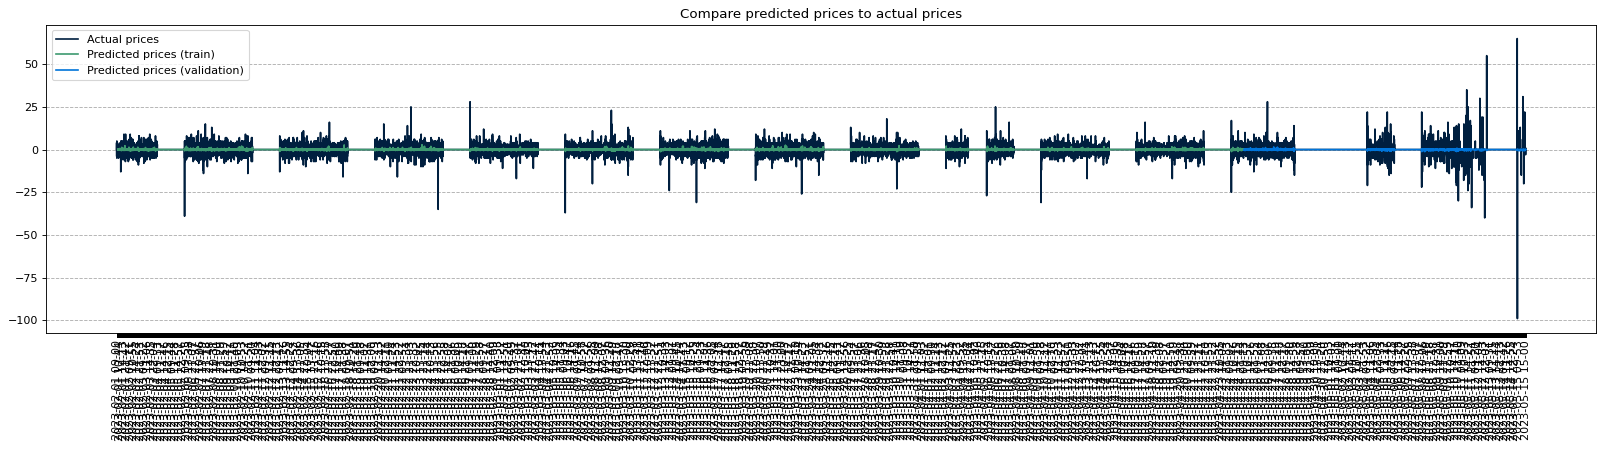

D:\Software\Python\torch\lib\site-packages\ipykernel_launcher.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


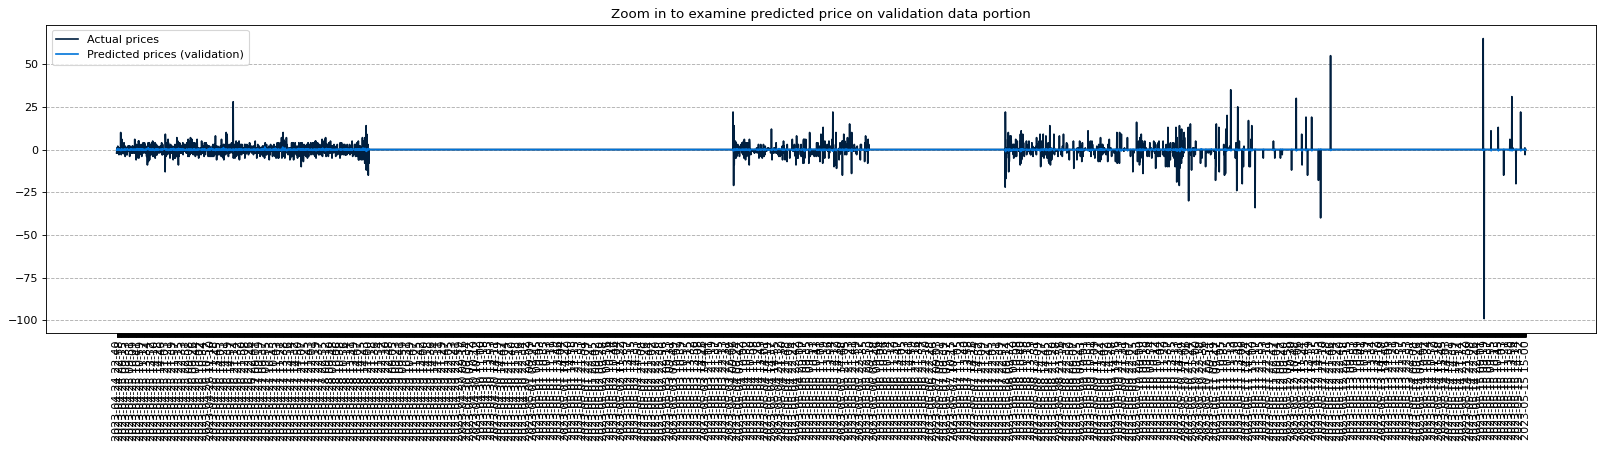

In [42]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

D:\Software\Python\torch\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


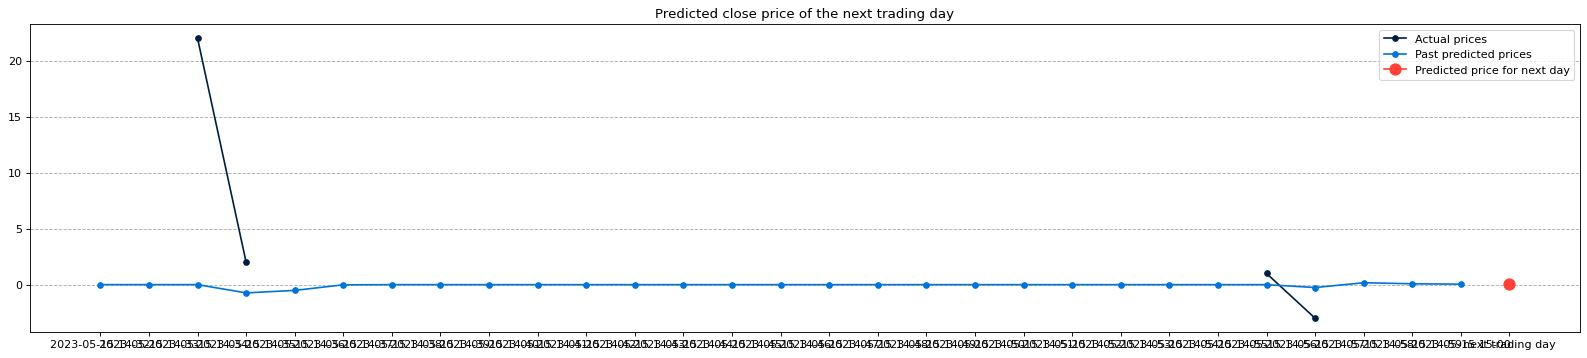

Predicted close price of the next trading day: 0.02


In [43]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 30
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))